# Some regularizations and optimization algorithms on [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
By [Zahra Taheri](https://github.com/zahta), November 25, 2020

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

# Set the seeds to ensure reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [ ]:
#Define path to the directory

path = os.getcwd()

mypath = path+"\Fashion-MNIST"

os.chdir(mypath)

print(os.getcwd())

C:\Users\Zahra\github\Deep_Learning_F20_Assignments\Assignments\Assignment_Set_8\Fashion-MNIST files\Fashion-MNIST


## Loading Fashion-MNIST into NumPy arrays

In [ ]:
from mlxtend.data import loadlocal_mnist

#load train_data and train_labels
train_data, train_labels= loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
#load test_data and test_labels
test_data, test_labels= loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

In [ ]:
print(train_data.shape)   # 28*28=784
print(train_labels.shape)

(60000, 784)
(60000,)


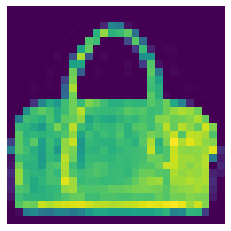

In [ ]:
some_digit = train_data[11000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)#, cmap = mpl.cm.binary)
plt.axis("off")
plt.show()

In [ ]:
from PIL import Image
import numpy as np

PIL_image = Image.fromarray(np.uint8(some_digit_image))

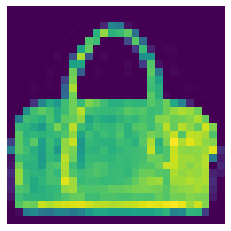

In [ ]:
plt.imshow(PIL_image)
plt.axis("off")
plt.show()

## Preparation of the dataset

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data= train_data.reshape((train_data.shape[0],28,28))
test_data= test_data.reshape((test_data.shape[0],28,28))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(train_data) # transform to torch tensor
tensor_y = torch.Tensor(train_labels)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your dataset

In [ ]:
tensor_x2 = torch.Tensor(test_data) # transform to torch tensor
tensor_y2 = torch.Tensor(test_labels)
tensor_y2 = tensor_y2.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x2,tensor_y2) # create your test dataset

In [ ]:
tensor_y

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
#train_dataset[0]

## Building Feedforward Neural Networks with PyTorch

In [ ]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100        
            
            

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt

## Regularizations (Ensemble Methods)

- [Ensembles: the only (almost) free Lunch in Machine Learning](https://towardsdatascience.com/ensembles-the-almost-free-lunch-in-machine-learning-91af7ebe5090)
    - Build optimal ensembles of neural networks with PyTorch and NumPy
    
    
- [Bagging and Dropout Learning](https://jrodthoughts.medium.com/bagging-and-dropout-learning-ae484023b0da)

### Dropout: Ensemble Method Interpretation
**Reference:** [Regularization by Sebastian Raschka](https://sebastianraschka.com/pdf/lecture-notes/stat479ss19/L10_regularization_slides.pdf)

- In DL, we typically don't do regular ensembling (majority vote over a large number of networks, bagging, etc.) because it is very expensive to fit neural nets.
- However, we know that the squared error for a prediction by a randomly selected model is larger than the squared error using an ensemble prediction (here, average over class probabilities).
- Now, in dropout, we have a different model for each minibatch. 
- Via the minibatch iterations, we essentially sample over $M=2^h$ models, where h is the number of hidden units.
- Restriction is that we have weight sharing over these models, which can be seen as a form of regularization.
- During "inference" we can then average over all these models (but this is very expensive). 
- However, using the last model after training and scaling the predictions by a factor 1/(1-p) approximates the geometric mean and is much cheaper (actually, it's exactly the geometric mean if we have a linear model).

### Dropout: More Practical Tips

- Don't use Dropout if your model does not overfit .
- However, in that case above, it is then recommended to increase the capacity to make it overfit, and then use dropout to be able to use a larger capacity model (but make it not overfit).



### Installing Ensemble-Pytorch package

In [ ]:
#!git clone https://github.com/AaronX121/Ensemble-Pytorch.git

In [ ]:
#mypath_ens = path+"\Ensemble-Pytorch"

#os.chdir(mypath_ens)

#print(os.getcwd())

In [ ]:
#!pip install -r requirements.txt

In [ ]:
#!python setup.py install

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 10.6171
Epoch: 001/025 | Batch 500/1200 | Cost: 0.5135
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.8741
Epoch: 001/025 Train Cost: 0.4831
Time elapsed: 0.09 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.7578
Epoch: 002/025 | Batch 500/1200 | Cost: 0.6242
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.5952
Epoch: 002/025 Train Cost: 0.4170
Time elapsed: 0.17 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.4579
Epoch: 003/025 | Batch 500/1200 | Cost: 0.6028
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.3749
Epoch: 003/025 Train Cost: 0.3869
Time elapsed: 0.25 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4719
Epoch: 004/025 | Batch 500/1200 | Cost: 0.5069
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.2200
Epoch: 004/025 Train Cost: 0.3771
Time elapsed: 0.34 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4536
Epoch: 005/025 | Batch 500/1200 | Cost: 0.4169
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.4524
Epoch: 005/025 Train Cost: 0.3564
Time elapsed: 0.42 min
Epoc

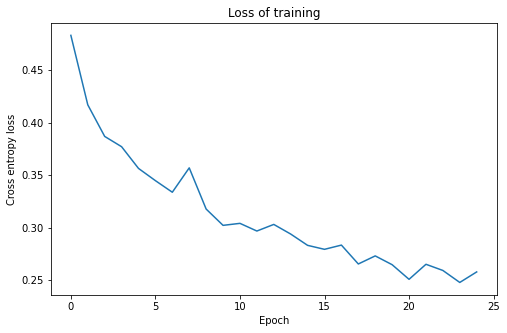

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.3098
Epoch: 001/010 | Batch 500/938 | Cost: 0.7345
Epoch: 001/010 Train Cost: 0.7354
Time elapsed: 0.14 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.9883
Epoch: 002/010 | Batch 500/938 | Cost: 0.5216
Epoch: 002/010 Train Cost: 0.4515
Time elapsed: 0.27 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.4773
Epoch: 003/010 | Batch 500/938 | Cost: 0.6437
Epoch: 003/010 Train Cost: 0.4160
Time elapsed: 0.41 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.4631
Epoch: 004/010 | Batch 500/938 | Cost: 0.3817
Epoch: 004/010 Train Cost: 0.3688
Time elapsed: 0.55 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.3687
Epoch: 005/010 | Batch 500/938 | Cost: 0.3891
Epoch: 005/010 Train Cost: 0.3734
Time elapsed: 0.68 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.3485
Epoch: 006/010 | Batch 500/938 | Cost: 0.3279
Epoch: 006/010 Train Cost: 0.3422
Time elapsed: 0.82 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.3202
Epoch: 007/010 | Batch 500/938 | Cost: 0.3279
Epoch: 007/010

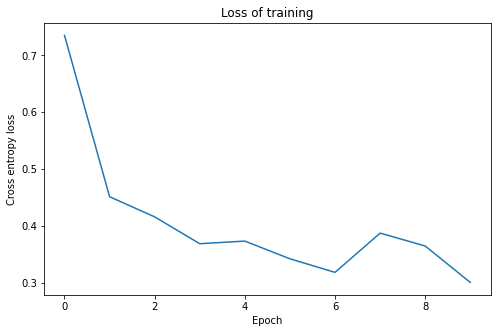

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 29.9145
Epoch: 001/020 Train Cost: 0.5175
Time elapsed: 0.08 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.5994
Epoch: 002/020 Train Cost: 0.4543
Time elapsed: 0.17 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.5682
Epoch: 003/020 Train Cost: 0.4264
Time elapsed: 0.26 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.3753
Epoch: 004/020 Train Cost: 0.3976
Time elapsed: 0.35 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.4163
Epoch: 005/020 Train Cost: 0.3826
Time elapsed: 0.43 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.4520
Epoch: 006/020 Train Cost: 0.3694
Time elapsed: 0.52 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.4888
Epoch: 007/020 Train Cost: 0.3600
Time elapsed: 0.61 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.3771
Epoch: 008/020 Train Cost: 0.3484
Time elapsed: 0.69 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.5312
Epoch: 009/020 Train Cost: 0.3423
Time elapsed: 0.77 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3125
Epoch: 010/020 Train Cost:

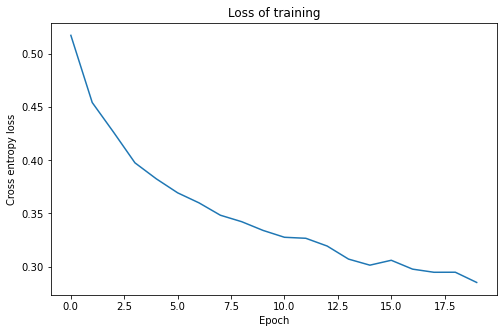

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## **Optimization:** Different optimizers and batch normalization

## 1. SGD

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 10.6171
Epoch: 001/025 | Batch 500/1200 | Cost: 0.5135
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.8741
Epoch: 001/025 Train Cost: 0.4831
Time elapsed: 0.10 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.7578
Epoch: 002/025 | Batch 500/1200 | Cost: 0.6242
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.5952
Epoch: 002/025 Train Cost: 0.4170
Time elapsed: 0.20 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.4579
Epoch: 003/025 | Batch 500/1200 | Cost: 0.6028
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.3749
Epoch: 003/025 Train Cost: 0.3869
Time elapsed: 0.32 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4719
Epoch: 004/025 | Batch 500/1200 | Cost: 0.5069
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.2200
Epoch: 004/025 Train Cost: 0.3771
Time elapsed: 0.43 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4536
Epoch: 005/025 | Batch 500/1200 | Cost: 0.4169
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.4524
Epoch: 005/025 Train Cost: 0.3564
Time elapsed: 0.53 min
Epoc

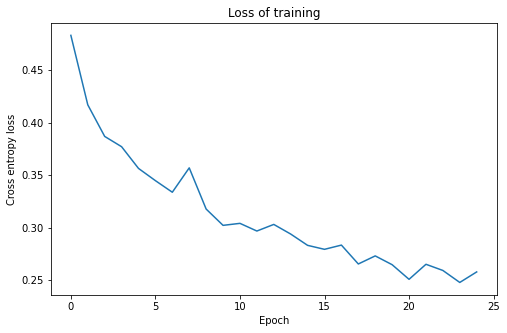

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.3075
Epoch: 001/010 | Batch 500/938 | Cost: 0.8356
Epoch: 001/010 Train Cost: 0.5662
Time elapsed: 0.14 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.7255
Epoch: 002/010 | Batch 500/938 | Cost: 0.3526
Epoch: 002/010 Train Cost: 0.5525
Time elapsed: 0.28 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.6087
Epoch: 003/010 | Batch 500/938 | Cost: 0.3082
Epoch: 003/010 Train Cost: 0.4212
Time elapsed: 0.42 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.3185
Epoch: 004/010 | Batch 500/938 | Cost: 0.6756
Epoch: 004/010 Train Cost: 0.3980
Time elapsed: 0.55 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.4428
Epoch: 005/010 | Batch 500/938 | Cost: 0.5048
Epoch: 005/010 Train Cost: 0.3538
Time elapsed: 0.68 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.4772
Epoch: 006/010 | Batch 500/938 | Cost: 0.4422
Epoch: 006/010 Train Cost: 0.3544
Time elapsed: 0.82 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.4580
Epoch: 007/010 | Batch 500/938 | Cost: 0.2587
Epoch: 007/010

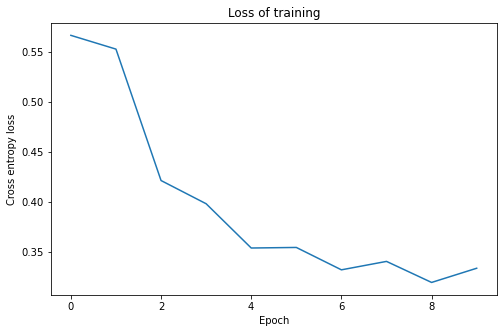

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 19.3792
Epoch: 001/020 Train Cost: 0.5213
Time elapsed: 0.09 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.5414
Epoch: 002/020 Train Cost: 0.4624
Time elapsed: 0.18 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.5918
Epoch: 003/020 Train Cost: 0.4400
Time elapsed: 0.26 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.5251
Epoch: 004/020 Train Cost: 0.4182
Time elapsed: 0.34 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.5184
Epoch: 005/020 Train Cost: 0.3910
Time elapsed: 0.41 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.3549
Epoch: 006/020 Train Cost: 0.3837
Time elapsed: 0.49 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3637
Epoch: 007/020 Train Cost: 0.3649
Time elapsed: 0.58 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.4600
Epoch: 008/020 Train Cost: 0.3551
Time elapsed: 0.66 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.3483
Epoch: 009/020 Train Cost: 0.3513
Time elapsed: 0.75 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3768
Epoch: 010/020 Train Cost:

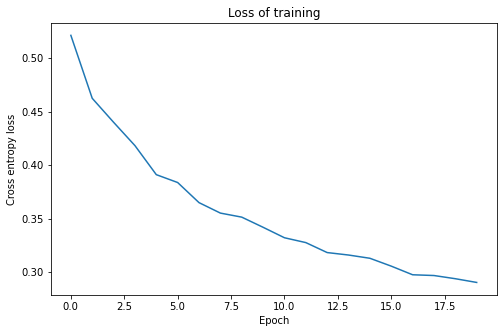

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 2. SGD Momentum

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 8.5049
Epoch: 001/025 | Batch 500/1200 | Cost: 0.5452
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.3211
Epoch: 001/025 Train Cost: 0.4538
Time elapsed: 0.10 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.5617
Epoch: 002/025 | Batch 500/1200 | Cost: 0.3931
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.3596
Epoch: 002/025 Train Cost: 0.4246
Time elapsed: 0.21 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.6886
Epoch: 003/025 | Batch 500/1200 | Cost: 0.2501
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.4241
Epoch: 003/025 Train Cost: 0.3552
Time elapsed: 0.31 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.3016
Epoch: 004/025 | Batch 500/1200 | Cost: 0.3040
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.4256
Epoch: 004/025 Train Cost: 0.3458
Time elapsed: 0.42 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4933
Epoch: 005/025 | Batch 500/1200 | Cost: 0.2163
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.3219
Epoch: 005/025 Train Cost: 0.3373
Time elapsed: 0.52 min
Epoch

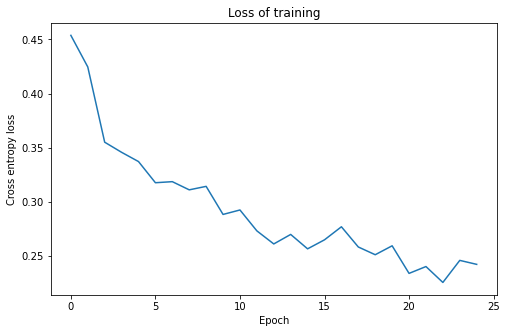

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.3341
Epoch: 001/010 | Batch 500/938 | Cost: 0.5022
Epoch: 001/010 Train Cost: 0.5068
Time elapsed: 0.17 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.4210
Epoch: 002/010 | Batch 500/938 | Cost: 0.5574
Epoch: 002/010 Train Cost: 0.4380
Time elapsed: 0.33 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.6859
Epoch: 003/010 | Batch 500/938 | Cost: 0.8856
Epoch: 003/010 Train Cost: 0.4181
Time elapsed: 0.48 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.3001
Epoch: 004/010 | Batch 500/938 | Cost: 0.4301
Epoch: 004/010 Train Cost: 0.3936
Time elapsed: 0.66 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.2687
Epoch: 005/010 | Batch 500/938 | Cost: 0.3217
Epoch: 005/010 Train Cost: 0.3666
Time elapsed: 0.83 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.1623
Epoch: 006/010 | Batch 500/938 | Cost: 0.6637
Epoch: 006/010 Train Cost: 0.3610
Time elapsed: 0.97 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.4979
Epoch: 007/010 | Batch 500/938 | Cost: 0.6525
Epoch: 007/010

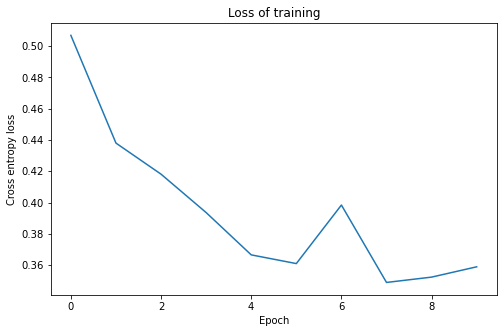

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 14.9508
Epoch: 001/020 Train Cost: 0.4694
Time elapsed: 0.09 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.5930
Epoch: 002/020 Train Cost: 0.4106
Time elapsed: 0.20 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.4124
Epoch: 003/020 Train Cost: 0.3756
Time elapsed: 0.30 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.5345
Epoch: 004/020 Train Cost: 0.3451
Time elapsed: 0.40 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.3537
Epoch: 005/020 Train Cost: 0.3351
Time elapsed: 0.50 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.5022
Epoch: 006/020 Train Cost: 0.3415
Time elapsed: 0.60 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3979
Epoch: 007/020 Train Cost: 0.3394
Time elapsed: 0.71 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.3287
Epoch: 008/020 Train Cost: 0.2988
Time elapsed: 0.81 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.3340
Epoch: 009/020 Train Cost: 0.3002
Time elapsed: 0.90 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3278
Epoch: 010/020 Train Cost:

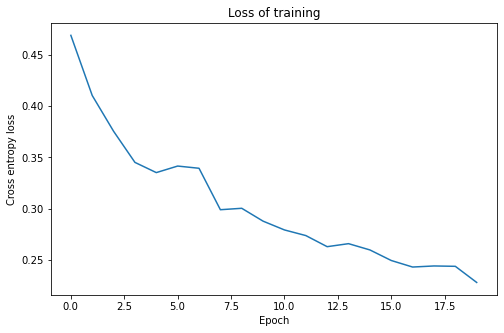

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 3. SGD Nesterov

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 8.5654
Epoch: 001/025 | Batch 500/1200 | Cost: 0.3510
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.5433
Epoch: 001/025 Train Cost: 0.4273
Time elapsed: 0.12 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.4838
Epoch: 002/025 | Batch 500/1200 | Cost: 0.3033
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.4329
Epoch: 002/025 Train Cost: 0.4171
Time elapsed: 0.25 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.4177
Epoch: 003/025 | Batch 500/1200 | Cost: 0.3094
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.3610
Epoch: 003/025 Train Cost: 0.3526
Time elapsed: 0.36 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4922
Epoch: 004/025 | Batch 500/1200 | Cost: 0.4868
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.4707
Epoch: 004/025 Train Cost: 0.3351
Time elapsed: 0.51 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.2675
Epoch: 005/025 | Batch 500/1200 | Cost: 0.2658
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.2594
Epoch: 005/025 Train Cost: 0.3308
Time elapsed: 0.65 min
Epoch

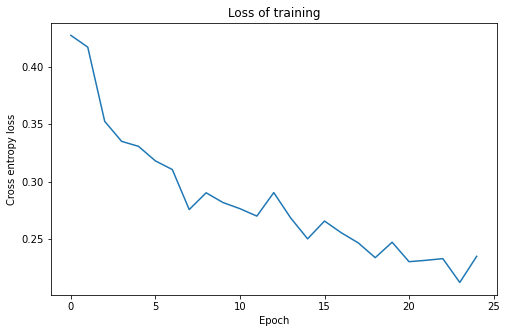

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6, nesterov=True)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.3248
Epoch: 001/010 | Batch 500/938 | Cost: 0.7324
Epoch: 001/010 Train Cost: 0.5478
Time elapsed: 0.14 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.4284
Epoch: 002/010 | Batch 500/938 | Cost: 0.3403
Epoch: 002/010 Train Cost: 0.4466
Time elapsed: 0.27 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.4631
Epoch: 003/010 | Batch 500/938 | Cost: 0.5025
Epoch: 003/010 Train Cost: 0.4087
Time elapsed: 0.41 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.4535
Epoch: 004/010 | Batch 500/938 | Cost: 0.3800
Epoch: 004/010 Train Cost: 0.4008
Time elapsed: 0.55 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.3436
Epoch: 005/010 | Batch 500/938 | Cost: 0.4253
Epoch: 005/010 Train Cost: 0.4070
Time elapsed: 0.69 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.4492
Epoch: 006/010 | Batch 500/938 | Cost: 0.3052
Epoch: 006/010 Train Cost: 0.3701
Time elapsed: 0.84 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.2543
Epoch: 007/010 | Batch 500/938 | Cost: 0.3921
Epoch: 007/010

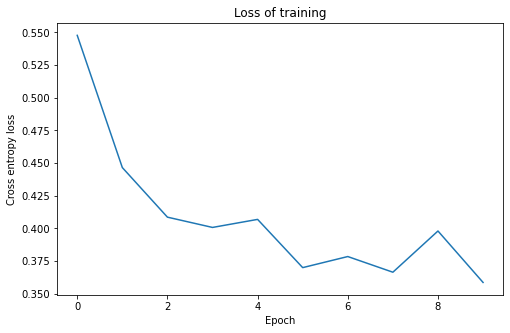

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, nesterov=True)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 18.2417
Epoch: 001/020 Train Cost: 0.5139
Time elapsed: 0.09 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.5035
Epoch: 002/020 Train Cost: 0.4180
Time elapsed: 0.20 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.3580
Epoch: 003/020 Train Cost: 0.3812
Time elapsed: 0.30 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.3783
Epoch: 004/020 Train Cost: 0.3646
Time elapsed: 0.42 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.3834
Epoch: 005/020 Train Cost: 0.3484
Time elapsed: 0.53 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.3406
Epoch: 006/020 Train Cost: 0.3298
Time elapsed: 0.64 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3934
Epoch: 007/020 Train Cost: 0.3308
Time elapsed: 0.75 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.3126
Epoch: 008/020 Train Cost: 0.3211
Time elapsed: 0.86 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.3010
Epoch: 009/020 Train Cost: 0.3078
Time elapsed: 0.95 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.4820
Epoch: 010/020 Train Cost:

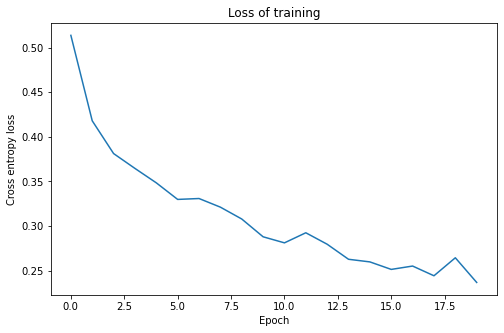

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 4. Adam

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 8.8686
Epoch: 001/025 | Batch 500/1200 | Cost: 0.8827
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.3954
Epoch: 001/025 Train Cost: 0.3933
Time elapsed: 0.15 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.5004
Epoch: 002/025 | Batch 500/1200 | Cost: 0.2573
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.4243
Epoch: 002/025 Train Cost: 0.4178
Time elapsed: 0.30 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.7105
Epoch: 003/025 | Batch 500/1200 | Cost: 0.2397
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.6516
Epoch: 003/025 Train Cost: 0.3970
Time elapsed: 0.45 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4573
Epoch: 004/025 | Batch 500/1200 | Cost: 0.3893
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.5636
Epoch: 004/025 Train Cost: 0.3869
Time elapsed: 0.63 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4465
Epoch: 005/025 | Batch 500/1200 | Cost: 0.4054
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.4030
Epoch: 005/025 Train Cost: 0.3341
Time elapsed: 0.81 min
Epoch

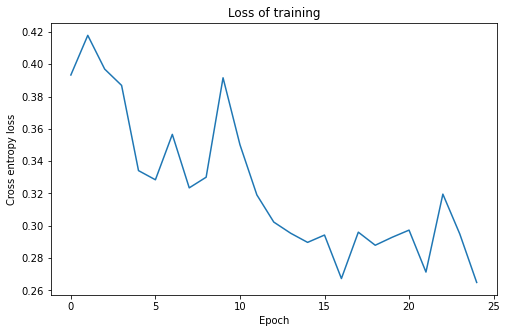

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.2978
Epoch: 001/010 | Batch 500/938 | Cost: 2.3039
Epoch: 001/010 Train Cost: 2.3056
Time elapsed: 0.23 min
Epoch: 002/010 | Batch 000/938 | Cost: 2.2958
Epoch: 002/010 | Batch 500/938 | Cost: 2.3119
Epoch: 002/010 Train Cost: 2.3063
Time elapsed: 0.50 min
Epoch: 003/010 | Batch 000/938 | Cost: 2.2925
Epoch: 003/010 | Batch 500/938 | Cost: 2.3015
Epoch: 003/010 Train Cost: 2.3058
Time elapsed: 0.77 min
Epoch: 004/010 | Batch 000/938 | Cost: 2.3069
Epoch: 004/010 | Batch 500/938 | Cost: 2.2941
Epoch: 004/010 Train Cost: 2.3061
Time elapsed: 1.05 min
Epoch: 005/010 | Batch 000/938 | Cost: 2.3093
Epoch: 005/010 | Batch 500/938 | Cost: 2.2927
Epoch: 005/010 Train Cost: 2.3060
Time elapsed: 1.33 min
Epoch: 006/010 | Batch 000/938 | Cost: 2.2951
Epoch: 006/010 | Batch 500/938 | Cost: 2.2985
Epoch: 006/010 Train Cost: 2.3061
Time elapsed: 1.60 min
Epoch: 007/010 | Batch 000/938 | Cost: 2.3008
Epoch: 007/010 | Batch 500/938 | Cost: 2.2988
Epoch: 007/010

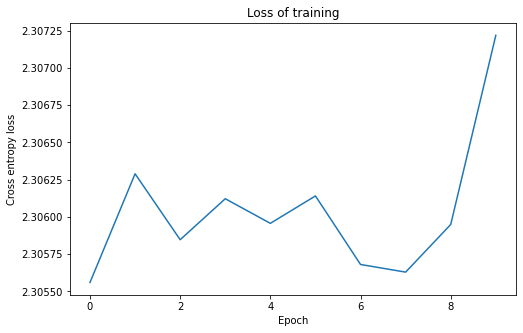

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 15.3351
Epoch: 001/020 Train Cost: 0.4165
Time elapsed: 0.08 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.4095
Epoch: 002/020 Train Cost: 0.4416
Time elapsed: 0.18 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.4118
Epoch: 003/020 Train Cost: 0.3845
Time elapsed: 0.29 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.4675
Epoch: 004/020 Train Cost: 0.3555
Time elapsed: 0.40 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.3699
Epoch: 005/020 Train Cost: 0.3450
Time elapsed: 0.51 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.4717
Epoch: 006/020 Train Cost: 0.3436
Time elapsed: 0.62 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3268
Epoch: 007/020 Train Cost: 0.3365
Time elapsed: 0.74 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.3923
Epoch: 008/020 Train Cost: 0.3331
Time elapsed: 0.85 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.2641
Epoch: 009/020 Train Cost: 0.3051
Time elapsed: 0.96 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3445
Epoch: 010/020 Train Cost:

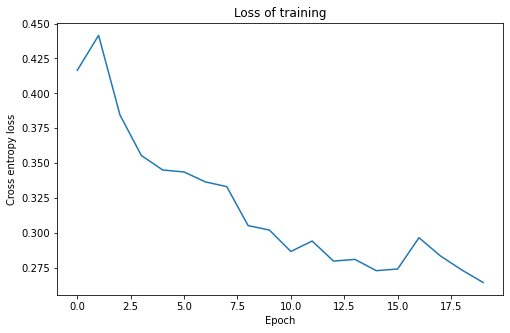

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 5. Adagrad

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adagrad(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 8.3976
Epoch: 001/025 | Batch 500/1200 | Cost: 0.5655
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.4008
Epoch: 001/025 Train Cost: 0.4375
Time elapsed: 0.10 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.2869
Epoch: 002/025 | Batch 500/1200 | Cost: 0.3452
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.2215
Epoch: 002/025 Train Cost: 0.3835
Time elapsed: 0.19 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.3905
Epoch: 003/025 | Batch 500/1200 | Cost: 0.4496
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.6216
Epoch: 003/025 Train Cost: 0.3700
Time elapsed: 0.28 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.5069
Epoch: 004/025 | Batch 500/1200 | Cost: 0.3781
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.4336
Epoch: 004/025 Train Cost: 0.3432
Time elapsed: 0.38 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4097
Epoch: 005/025 | Batch 500/1200 | Cost: 0.3066
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.3469
Epoch: 005/025 Train Cost: 0.3278
Time elapsed: 0.47 min
Epoch

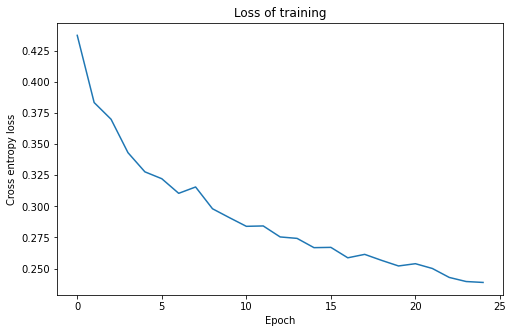

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adagrad(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.2655
Epoch: 001/010 | Batch 500/938 | Cost: 0.8899
Epoch: 001/010 Train Cost: 0.9294
Time elapsed: 0.13 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.9593
Epoch: 002/010 | Batch 500/938 | Cost: 0.8712
Epoch: 002/010 Train Cost: 0.8486
Time elapsed: 0.26 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.7526
Epoch: 003/010 | Batch 500/938 | Cost: 0.8231
Epoch: 003/010 Train Cost: 0.6823
Time elapsed: 0.39 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.5277
Epoch: 004/010 | Batch 500/938 | Cost: 0.7090
Epoch: 004/010 Train Cost: 0.6310
Time elapsed: 0.52 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.5494
Epoch: 005/010 | Batch 500/938 | Cost: 0.5803
Epoch: 005/010 Train Cost: 0.5987
Time elapsed: 0.65 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.7327
Epoch: 006/010 | Batch 500/938 | Cost: 0.7192
Epoch: 006/010 Train Cost: 0.5601
Time elapsed: 0.78 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.6972
Epoch: 007/010 | Batch 500/938 | Cost: 0.5836
Epoch: 007/010

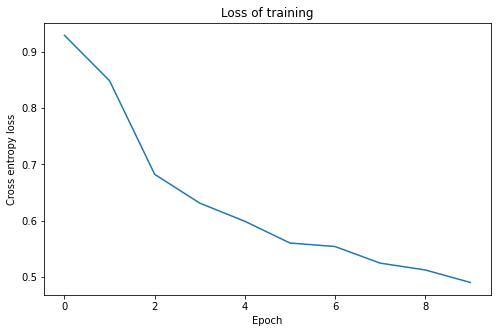

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adagrad(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 16.2471
Epoch: 001/020 Train Cost: 0.4827
Time elapsed: 0.08 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.4442
Epoch: 002/020 Train Cost: 0.4183
Time elapsed: 0.15 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.5949
Epoch: 003/020 Train Cost: 0.3801
Time elapsed: 0.23 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.3647
Epoch: 004/020 Train Cost: 0.3555
Time elapsed: 0.30 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.3433
Epoch: 005/020 Train Cost: 0.3453
Time elapsed: 0.38 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.5519
Epoch: 006/020 Train Cost: 0.3265
Time elapsed: 0.45 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.2974
Epoch: 007/020 Train Cost: 0.3213
Time elapsed: 0.53 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.4408
Epoch: 008/020 Train Cost: 0.3189
Time elapsed: 0.60 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.3013
Epoch: 009/020 Train Cost: 0.3057
Time elapsed: 0.68 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3685
Epoch: 010/020 Train Cost:

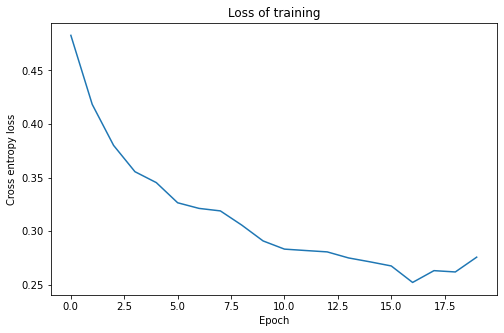

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 6. Adadelta

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adadelta(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 7.7024
Epoch: 001/025 | Batch 500/1200 | Cost: 1.1054
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.7935
Epoch: 001/025 Train Cost: 0.5672
Time elapsed: 0.11 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.7114
Epoch: 002/025 | Batch 500/1200 | Cost: 0.5179
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.4342
Epoch: 002/025 Train Cost: 0.5207
Time elapsed: 0.23 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.6736
Epoch: 003/025 | Batch 500/1200 | Cost: 0.6750
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.3104
Epoch: 003/025 Train Cost: 0.4641
Time elapsed: 0.35 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4405
Epoch: 004/025 | Batch 500/1200 | Cost: 0.6065
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.5799
Epoch: 004/025 Train Cost: 0.4893
Time elapsed: 0.47 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.5169
Epoch: 005/025 | Batch 500/1200 | Cost: 0.8205
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.4489
Epoch: 005/025 Train Cost: 0.4601
Time elapsed: 0.59 min
Epoch

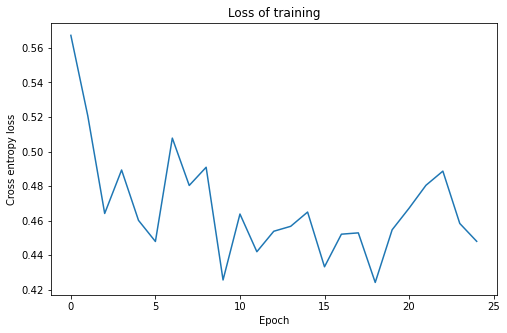

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adadelta(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.2894
Epoch: 001/010 | Batch 500/938 | Cost: 0.6015
Epoch: 001/010 Train Cost: 0.6799
Time elapsed: 0.16 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.6634
Epoch: 002/010 | Batch 500/938 | Cost: 0.6491
Epoch: 002/010 Train Cost: 0.7818
Time elapsed: 0.32 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.8108
Epoch: 003/010 | Batch 500/938 | Cost: 0.3926
Epoch: 003/010 Train Cost: 0.6355
Time elapsed: 0.48 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.7905
Epoch: 004/010 | Batch 500/938 | Cost: 0.5237
Epoch: 004/010 Train Cost: 0.6305
Time elapsed: 0.64 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.6715
Epoch: 005/010 | Batch 500/938 | Cost: 0.7226
Epoch: 005/010 Train Cost: 0.5789
Time elapsed: 0.80 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.9474
Epoch: 006/010 | Batch 500/938 | Cost: 0.5457
Epoch: 006/010 Train Cost: 0.5296
Time elapsed: 0.97 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.4170
Epoch: 007/010 | Batch 500/938 | Cost: 0.5223
Epoch: 007/010

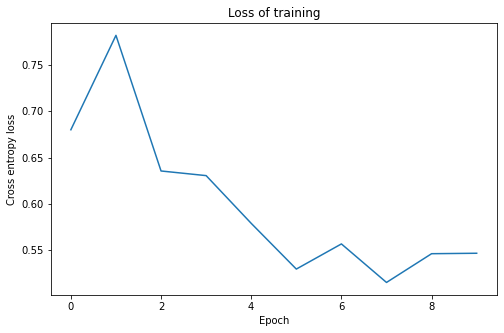

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adadelta(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 17.3316
Epoch: 001/020 Train Cost: 0.5632
Time elapsed: 0.09 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.6148
Epoch: 002/020 Train Cost: 0.4837
Time elapsed: 0.18 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.4882
Epoch: 003/020 Train Cost: 0.5022
Time elapsed: 0.27 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.6282
Epoch: 004/020 Train Cost: 0.4913
Time elapsed: 0.37 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.4370
Epoch: 005/020 Train Cost: 0.4971
Time elapsed: 0.47 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.7260
Epoch: 006/020 Train Cost: 0.4208
Time elapsed: 0.57 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3456
Epoch: 007/020 Train Cost: 0.5088
Time elapsed: 0.67 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.5226
Epoch: 008/020 Train Cost: 0.5134
Time elapsed: 0.78 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.4951
Epoch: 009/020 Train Cost: 0.5282
Time elapsed: 0.90 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.6942
Epoch: 010/020 Train Cost:

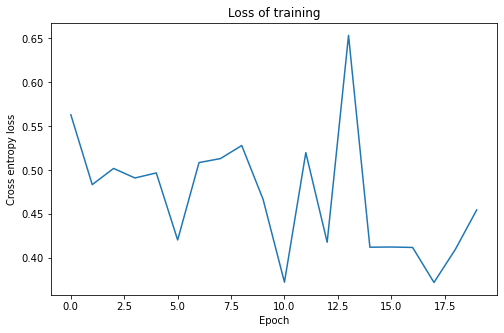

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 7. Adamax

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adamax(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 11.6429
Epoch: 001/025 | Batch 500/1200 | Cost: 0.8117
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.4805
Epoch: 001/025 Train Cost: 0.4404
Time elapsed: 0.17 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.3387
Epoch: 002/025 | Batch 500/1200 | Cost: 0.4540
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.3128
Epoch: 002/025 Train Cost: 0.3920
Time elapsed: 0.33 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.4423
Epoch: 003/025 | Batch 500/1200 | Cost: 0.3205
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.6096
Epoch: 003/025 Train Cost: 0.3549
Time elapsed: 0.51 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.4785
Epoch: 004/025 | Batch 500/1200 | Cost: 0.3516
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.6095
Epoch: 004/025 Train Cost: 0.3256
Time elapsed: 0.70 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.2406
Epoch: 005/025 | Batch 500/1200 | Cost: 0.4350
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.2959
Epoch: 005/025 Train Cost: 0.3519
Time elapsed: 0.86 min
Epoc

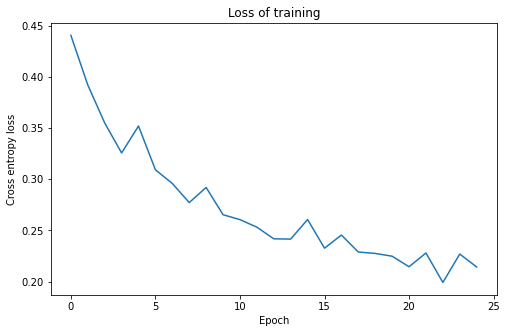

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adamax(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.3112
Epoch: 001/010 | Batch 500/938 | Cost: 0.4316
Epoch: 001/010 Train Cost: 0.5153
Time elapsed: 0.22 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.4270
Epoch: 002/010 | Batch 500/938 | Cost: 0.3160
Epoch: 002/010 Train Cost: 0.4812
Time elapsed: 0.44 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.4479
Epoch: 003/010 | Batch 500/938 | Cost: 0.4080
Epoch: 003/010 Train Cost: 0.4168
Time elapsed: 0.66 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.5480
Epoch: 004/010 | Batch 500/938 | Cost: 0.4322
Epoch: 004/010 Train Cost: 0.4058
Time elapsed: 0.90 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.2489
Epoch: 005/010 | Batch 500/938 | Cost: 0.4844
Epoch: 005/010 Train Cost: 0.3932
Time elapsed: 1.14 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.1621
Epoch: 006/010 | Batch 500/938 | Cost: 0.4372
Epoch: 006/010 Train Cost: 0.3583
Time elapsed: 1.38 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.4497
Epoch: 007/010 | Batch 500/938 | Cost: 0.2473
Epoch: 007/010

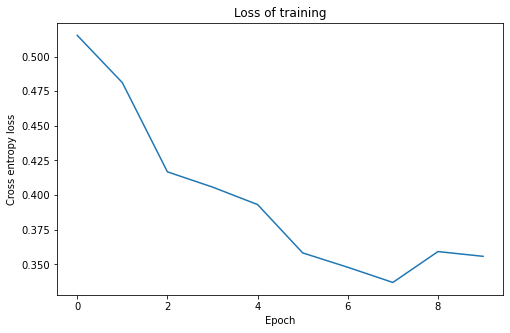

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adamax(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 17.2844
Epoch: 001/020 Train Cost: 0.4647
Time elapsed: 0.13 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.4278
Epoch: 002/020 Train Cost: 0.4007
Time elapsed: 0.25 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.7549
Epoch: 003/020 Train Cost: 0.3684
Time elapsed: 0.41 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.3838
Epoch: 004/020 Train Cost: 0.3562
Time elapsed: 0.55 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.5114
Epoch: 005/020 Train Cost: 0.3600
Time elapsed: 0.67 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.4716
Epoch: 006/020 Train Cost: 0.3421
Time elapsed: 0.80 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3855
Epoch: 007/020 Train Cost: 0.3212
Time elapsed: 0.92 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.2875
Epoch: 008/020 Train Cost: 0.3236
Time elapsed: 1.04 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.2860
Epoch: 009/020 Train Cost: 0.2930
Time elapsed: 1.16 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.2989
Epoch: 010/020 Train Cost:

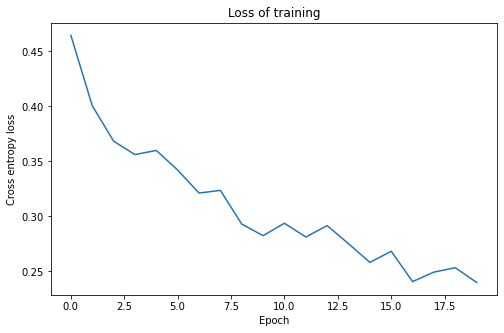

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## 8. RMSProp

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # non-linearity 1
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
           Dropout-7               [-1, 1, 100]               0
            Linear-8                [-1, 1, 10]           1,010
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 9.9008
Epoch: 001/025 | Batch 500/1200 | Cost: 0.4995
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.3256
Epoch: 001/025 Train Cost: 0.5188
Time elapsed: 0.10 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.3108
Epoch: 002/025 | Batch 500/1200 | Cost: 0.8537
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.7005
Epoch: 002/025 Train Cost: 0.4060
Time elapsed: 0.20 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.9386
Epoch: 003/025 | Batch 500/1200 | Cost: 0.1984
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.3070
Epoch: 003/025 Train Cost: 0.3938
Time elapsed: 0.29 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.3267
Epoch: 004/025 | Batch 500/1200 | Cost: 0.2171
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.5845
Epoch: 004/025 Train Cost: 0.3797
Time elapsed: 0.39 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.4946
Epoch: 005/025 | Batch 500/1200 | Cost: 0.4120
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.4303
Epoch: 005/025 Train Cost: 0.3525
Time elapsed: 0.50 min
Epoch

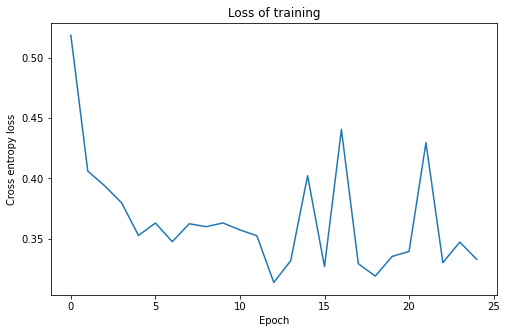

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.sigmoid = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.sigmoid(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (sigmoid): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]          78,500
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              ReLU-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 200]          20,200
              Tanh-6               [-1, 1, 200]               0
            Linear-7               [-1, 1, 300]          60,300
              ReLU-8               [-1, 1, 300]               0
           Dropout-9               [-1, 1, 300]               0
           Linear-10               [-1, 1, 100]          30,100
             ReLU-11               [-1, 1, 100]               0
          Dropout-12               [-1, 1, 100]               0
           Linear-13                [-1, 1, 10]           1,010
Total params: 200,210
Trainable params:

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.2730
Epoch: 001/010 | Batch 500/938 | Cost: 2.3005
Epoch: 001/010 Train Cost: 2.3058
Time elapsed: 0.13 min
Epoch: 002/010 | Batch 000/938 | Cost: 2.2991
Epoch: 002/010 | Batch 500/938 | Cost: 2.3004
Epoch: 002/010 Train Cost: 2.3056
Time elapsed: 0.26 min
Epoch: 003/010 | Batch 000/938 | Cost: 2.3012
Epoch: 003/010 | Batch 500/938 | Cost: 2.3015
Epoch: 003/010 Train Cost: 2.3054
Time elapsed: 0.40 min
Epoch: 004/010 | Batch 000/938 | Cost: 2.3032
Epoch: 004/010 | Batch 500/938 | Cost: 2.3085
Epoch: 004/010 Train Cost: 2.3060
Time elapsed: 0.54 min
Epoch: 005/010 | Batch 000/938 | Cost: 2.3105
Epoch: 005/010 | Batch 500/938 | Cost: 2.2948
Epoch: 005/010 Train Cost: 2.3059
Time elapsed: 0.68 min
Epoch: 006/010 | Batch 000/938 | Cost: 2.3065
Epoch: 006/010 | Batch 500/938 | Cost: 2.3052
Epoch: 006/010 Train Cost: 2.3061
Time elapsed: 0.85 min
Epoch: 007/010 | Batch 000/938 | Cost: 2.2963
Epoch: 007/010 | Batch 500/938 | Cost: 2.3028
Epoch: 007/010

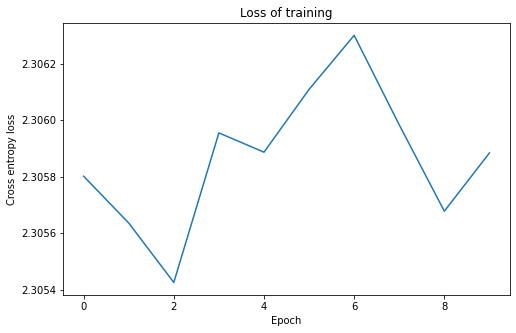

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
           Dropout-5               [-1, 1, 128]               0
            Linear-6                [-1, 1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 22.8726
Epoch: 001/020 Train Cost: 0.5393
Time elapsed: 0.08 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.6775
Epoch: 002/020 Train Cost: 0.4049
Time elapsed: 0.15 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.3771
Epoch: 003/020 Train Cost: 0.3746
Time elapsed: 0.23 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.3294
Epoch: 004/020 Train Cost: 0.7438
Time elapsed: 0.31 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.9107
Epoch: 005/020 Train Cost: 0.3591
Time elapsed: 0.38 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.3547
Epoch: 006/020 Train Cost: 0.3595
Time elapsed: 0.45 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.3742
Epoch: 007/020 Train Cost: 0.3939
Time elapsed: 0.52 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.3857
Epoch: 008/020 Train Cost: 0.3474
Time elapsed: 0.60 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.6419
Epoch: 009/020 Train Cost: 0.3459
Time elapsed: 0.68 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.3547
Epoch: 010/020 Train Cost:

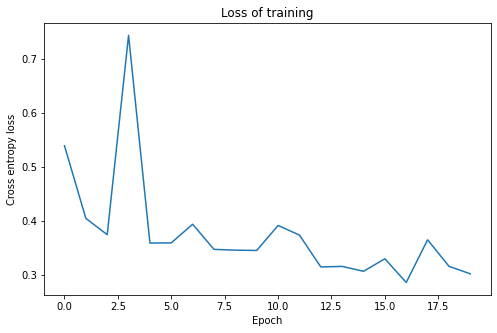

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Batch normalization

### Model B: 3 Hidden Layers Feedforward Neural Network (ReLU Activation)

#### Make dataset iterable

In [ ]:
batch_size = 50
n_iters = 30000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

25


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

#### Create model class

In [ ]:
class FeedforwardNeuralNetworkModel1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNeuralNetworkModel1, self).__init__()
        # linear function 1: 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim)       
        self.relu1 = nn.ReLU()
        
        # linear function 2: 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # non-linearity 2
        self.relu2 = nn.ReLU()
        
        # linear function 3: 
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim)
        # non-linearity 3
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # linear function 4 (readout)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        # linear function 1
        out = self.fc1(x)
        out = self.BatchNorm1d2(out)
        # non-linearity 1
        out = self.relu1(out)
        #out = self.dropout1(out)
        
        # linear function 2
        out = self.fc2(out)
        
        # non-linearity 2
        out = self.relu2(out)
        
        # linear function 3
        out = self.fc3(out)
        #print(out.shape)
        out = self.BatchNorm1d1(out)
        # non-linearity 3
        out = self.relu3(out)
        out = self.dropout2(out)
        
        #linear function 4 (readout)
        out = self.fc4(out)
        return out       
    

In [ ]:
#  Instantiate model class
input_dim = 28*28
output_dim = 10
hidden_dim = 100 

model = FeedforwardNeuralNetworkModel1(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)
    

FeedforwardNeuralNetworkModel1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (BatchNorm1d2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (BatchNorm1d1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
#summary(model, (1,28*28))

In [ ]:
#  Instantiate loss class
criterion=nn.CrossEntropyLoss()

#  Instantiate optimizer class
learning_rate = 0.001
optimizer = torch.optim.Adamax(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/025 | Batch 000/1200 | Cost: 2.4135
Epoch: 001/025 | Batch 500/1200 | Cost: 0.6535
Epoch: 001/025 | Batch 1000/1200 | Cost: 0.5050
Epoch: 001/025 Train Cost: 0.3369
Time elapsed: 0.23 min
Epoch: 002/025 | Batch 000/1200 | Cost: 0.6091
Epoch: 002/025 | Batch 500/1200 | Cost: 0.4359
Epoch: 002/025 | Batch 1000/1200 | Cost: 0.4161
Epoch: 002/025 Train Cost: 0.2935
Time elapsed: 0.45 min
Epoch: 003/025 | Batch 000/1200 | Cost: 0.5837
Epoch: 003/025 | Batch 500/1200 | Cost: 0.6271
Epoch: 003/025 | Batch 1000/1200 | Cost: 0.4783
Epoch: 003/025 Train Cost: 0.2997
Time elapsed: 0.67 min
Epoch: 004/025 | Batch 000/1200 | Cost: 0.3344
Epoch: 004/025 | Batch 500/1200 | Cost: 0.2775
Epoch: 004/025 | Batch 1000/1200 | Cost: 0.5176
Epoch: 004/025 Train Cost: 0.2613
Time elapsed: 0.90 min
Epoch: 005/025 | Batch 000/1200 | Cost: 0.3315
Epoch: 005/025 | Batch 500/1200 | Cost: 0.2240
Epoch: 005/025 | Batch 1000/1200 | Cost: 0.2903
Epoch: 005/025 Train Cost: 0.2390
Time elapsed: 1.13 min
Epoch

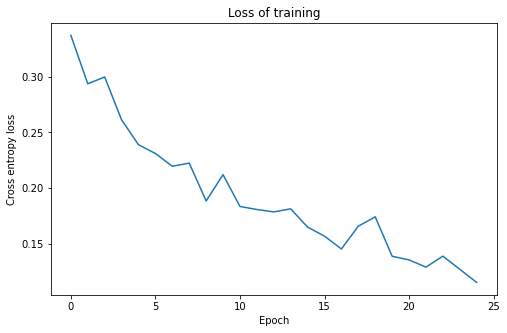

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model C: 5 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 64
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 100 
hidden_dim2 = 100 
hidden_dim3 = 200 
hidden_dim4 = 300 
hidden_dim5 = 100 

#### Create model class

In [ ]:
class FNNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim):
        
        super(FNNModel2, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.f3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.tanh = nn.Tanh()
        
        self.f4 = nn.Linear(hidden_dim3,hidden_dim4)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        
        self.f5 = nn.Linear(hidden_dim4,hidden_dim5)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim5)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.f6 = nn.Linear(hidden_dim5,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.BatchNorm1d1(out)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.relu2(out)
        
        out = self.f3(out)
        out = self.tanh(out)
        
        out = self.f4(out)
        out = self.relu3(out)
        out = self.dropout1(out)
        
        out = self.f5(out)
        out = self.BatchNorm1d2(out)
        out = self.relu4(out)
        out = self.dropout2(out)
        
        out = self.f6(out)
        
        return out       
    

In [ ]:
model = FNNModel2(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel2(
  (f1): Linear(in_features=784, out_features=100, bias=True)
  (BatchNorm1d1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (f2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (f3): Linear(in_features=100, out_features=200, bias=True)
  (tanh): Tanh()
  (f4): Linear(in_features=200, out_features=300, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.25, inplace=False)
  (f5): Linear(in_features=300, out_features=100, bias=True)
  (BatchNorm1d2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (f6): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
#summary(model, (1,28*28))

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.6)

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/010 | Batch 000/938 | Cost: 2.4586
Epoch: 001/010 | Batch 500/938 | Cost: 0.4836
Epoch: 001/010 Train Cost: 0.3703
Time elapsed: 0.20 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.3019
Epoch: 002/010 | Batch 500/938 | Cost: 0.5733
Epoch: 002/010 Train Cost: 0.3863
Time elapsed: 0.39 min
Epoch: 003/010 | Batch 000/938 | Cost: 0.3728
Epoch: 003/010 | Batch 500/938 | Cost: 0.3301
Epoch: 003/010 Train Cost: 0.2889
Time elapsed: 0.58 min
Epoch: 004/010 | Batch 000/938 | Cost: 0.4510
Epoch: 004/010 | Batch 500/938 | Cost: 0.2700
Epoch: 004/010 Train Cost: 0.3016
Time elapsed: 0.78 min
Epoch: 005/010 | Batch 000/938 | Cost: 0.2780
Epoch: 005/010 | Batch 500/938 | Cost: 0.3505
Epoch: 005/010 Train Cost: 0.2700
Time elapsed: 0.98 min
Epoch: 006/010 | Batch 000/938 | Cost: 0.3885
Epoch: 006/010 | Batch 500/938 | Cost: 0.1032
Epoch: 006/010 Train Cost: 0.2699
Time elapsed: 1.17 min
Epoch: 007/010 | Batch 000/938 | Cost: 0.4011
Epoch: 007/010 | Batch 500/938 | Cost: 0.2558
Epoch: 007/010

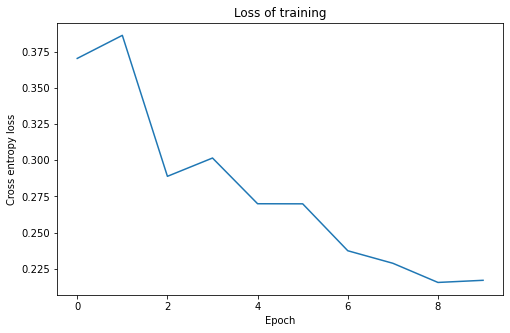

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

### Model D: 3 Hidden Layers Feedforward Neural Network

#### Make dataset iterable

In [ ]:
batch_size = 128
n_iters = 9400
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

20

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # create your dataloader

test_loader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False)

In [ ]:
input_dim = 28*28
output_dim = 10
hidden_dim1 = 256
hidden_dim2 = 128 

#### Create model class

In [ ]:
class FNNModel3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        
        super(FNNModel3, self).__init__()
        
        self.f1 = nn.Linear(input_dim,hidden_dim1)
        self.BatchNorm1d1=nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        
        self.f2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.BatchNorm1d2=nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        self.f3 = nn.Linear(hidden_dim2,output_dim)
        
    def forward(self, x):
        out = self.f1(x)
        out = self.BatchNorm1d1(out)
        out = self.relu1(out)

        out = self.f2(out)
        out = self.BatchNorm1d2(out)
        out = self.relu2(out)
        out = self.dropout1(out)
        
        out = self.f3(out)
        
        return out       
    

In [ ]:
model = FNNModel3(input_dim, hidden_dim1, hidden_dim2, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
model.to(device)

FNNModel3(
  (f1): Linear(in_features=784, out_features=256, bias=True)
  (BatchNorm1d1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (f2): Linear(in_features=256, out_features=128, bias=True)
  (BatchNorm1d2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (f3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
#summary(model, (1,28*28))

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adamax(model.parameters())

#### Train the model

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/469 | Cost: 2.3862
Epoch: 001/020 Train Cost: 0.3417
Time elapsed: 0.16 min
Epoch: 002/020 | Batch 000/469 | Cost: 0.3215
Epoch: 002/020 Train Cost: 0.2946
Time elapsed: 0.31 min
Epoch: 003/020 | Batch 000/469 | Cost: 0.2720
Epoch: 003/020 Train Cost: 0.2844
Time elapsed: 0.46 min
Epoch: 004/020 | Batch 000/469 | Cost: 0.2998
Epoch: 004/020 Train Cost: 0.2536
Time elapsed: 0.61 min
Epoch: 005/020 | Batch 000/469 | Cost: 0.2466
Epoch: 005/020 Train Cost: 0.2511
Time elapsed: 0.76 min
Epoch: 006/020 | Batch 000/469 | Cost: 0.2597
Epoch: 006/020 Train Cost: 0.2204
Time elapsed: 0.91 min
Epoch: 007/020 | Batch 000/469 | Cost: 0.1734
Epoch: 007/020 Train Cost: 0.2106
Time elapsed: 1.07 min
Epoch: 008/020 | Batch 000/469 | Cost: 0.2171
Epoch: 008/020 Train Cost: 0.2254
Time elapsed: 1.22 min
Epoch: 009/020 | Batch 000/469 | Cost: 0.2218
Epoch: 009/020 Train Cost: 0.2048
Time elapsed: 1.37 min
Epoch: 010/020 | Batch 000/469 | Cost: 0.1730
Epoch: 010/020 Train Cost: 

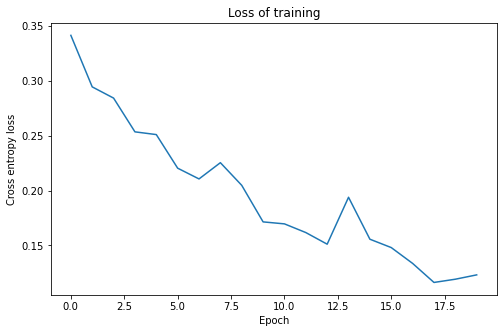

In [ ]:
#Plot the loss curve

plt.figure(figsize=(8,5))
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss of training")
plt.show()

## Results of regularizations

| Model Name                    | Training Accuracy | Test Accuracy | Training Accuracy(Dropout) | Test Accuracy(Dropout) | 
|--------------------------------|----------|----------|----------|----------|
| Model B |  92.20  |  87.53  |  90.30   |  87.09   |
| Model C |  87.74  |  85.76  |  88.98   |  86.54   |
| Model D |  90.90  |  86.56  |  89.48   |  86.57   |

## Results of optimizations (Test accuracy)
- With dropouts from the regularization part
- Best optimizer for each model is bolded

| Optimizer                    | Model B | Model C | Model D | 
|--------------------------------|----------|----------|----------|
| SGD |  87.09  |  85.11  |  86.44  |
| **SGD Momentum** |  87.27  |  **85.46**  |  87.61   |
| SGD Nesterov |  87.33  |  85.12  |  87.64   |
| Adam |  86.86  |  10.00  |   86.74  |
| Adagrad |  87.63  |  80.76  |   86.42  |
| Adadelta |  83.92  |  80.15  |  81.50   |
| **Adamax** |  **87.91**  |  84.82  |  **87.98**   |
| RMSProp |  85.66  |  10.00  |  86.03  |


### Batch normalozation
- With dropouts from the regularization part
- We employed the best optimizer for the models from the previous table

| Model Name | Optimizer| Training Accuracy | Test Accuracy |
|------------|----------|----------|----------|
| Model B |  Adamax  |  95.55  | 89.25  |
| Model C |  SGD Momentum  |  92.11  |  88.38  |
| Model D |  Adamax  |  95.23  |  88.55  |
